# 라이브러리

In [4]:
!pip install sentence-transformers
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 317.1 kB/s eta 0:00:00a 0:00:01


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

In [68]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

# 네이버 뉴스로 유사도 추출

In [ ]:
# 데이터 불러오기
news_df = pd.read_csv('/Users/han-yeeun/final/db/news_2023_2025.csv')

In [45]:
news_df.head()

,news_id,wdate,title,article,press,url,image
0,20250523_0001,2025-05-23 19:11,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목,"2035년 종료 앞둬, 존속 공약에 기대감\n창업 초기자금 공백 완화 가능성에 업계...",이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/05/...
1,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...
2,20250523_0003,2025-05-23 18:38,"키스트론, 일반 청약 흥행…증거금 6조원 모았다","5월22~23일 청약 진행, 경쟁률 총2166대1\n상장 후 예상 시가총개 643억...",머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...
3,20250523_0004,2025-05-23 18:33,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...
4,20250523_0005,2025-05-23 18:24,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...


In [6]:
# 기업명 및 유사도 추출 개수 설정
target_company = '삼성전자'
top_n = 5

In [78]:
# 날짜 형식 변환
news_df['wdate'] = pd.to_datetime(news_df['wdate'])

In [79]:
# 기준 뉴스 선택 (해당 기업 포함 + 가장 최신 기사 1건)
filtered_df = news_df[
    (news_df['title'].str.contains(target_company, na=False)) &
    (news_df['wdate'].dt.year == 2025)
].sort_values('wdate', ascending=False)

if not filtered_df.empty:
    target_news = filtered_df.iloc[0]
    target_content = target_news['article']
    target_date = target_news['wdate']
else:
    print(f"[주의] '{target_company}' 관련 2025년 뉴스가 없습니다.")
    target_news = None
    target_content = ""
    target_date = pd.NaT

In [80]:
target_news['url']

'https://n.news.naver.com/mnews/article/011/0004487837'

In [ ]:
# 비교군 설정
# - 2022~2024년
# - 최소 6개월 전
# - 기업명 포함

min_gap_days = 180  # 6개월 기준

compare_df = news_df[
    (news_df['wdate'].dt.year >= 2022) &
    (news_df['wdate'].dt.year <= 2024) &
    ((news_df['title'].str.contains(target_company, na=False)) |
     (news_df['article'].str.contains(target_company, na=False))) &
    (news_df['wdate'] <= target_date - timedelta(days=min_gap_days))
].reset_index(drop=True)

In [82]:
# 유사 뉴스 찾기
def find_similar_news(model_name):
    print(f'\n모델: {model_name}')
    model = SentenceTransformer(model_name)

    start = time()
    target_embedding = model.encode([target_content])
    compare_embeddings = model.encode(compare_df['article'].tolist(), show_progress_bar=True)
    print(f'임베딩 완료: {time() - start:.2f}초')

    similarities = cosine_similarity(target_embedding, compare_embeddings)[0]
    compare_df['similarity'] = similarities
    compare_df['wdate'] = pd.to_datetime(compare_df['wdate'], errors='coerce')
    compare_df_sorted = compare_df.sort_values(by='similarity', ascending=False).dropna(subset=['wdate'])

    # 기준 뉴스 날짜
    target_date = target_news['wdate']
    selected = []

    for _, row in compare_df_sorted.iterrows():
        candidate_date = row['wdate']

        # 조건 1: 기준 기사와 시차 ≥ 6개월
        if abs((target_date - candidate_date).days) < 180:
            continue

        # 조건 2: 기존 선택 뉴스들과 시차 ≥ 3개월
        if any(abs((candidate_date - sel['wdate']).days) < 90 for sel in selected):
            continue

        selected.append(row)
        if len(selected) == top_n:
            break

    result = pd.DataFrame(selected)
    return result

In [83]:
# 실행 1
result1 = find_similar_news('jhgan/ko-sbert-sts')

# 실행 2
result2 = find_similar_news('snunlp/KR-SBERT-V40K-klueNLI-augSTS')


모델: jhgan/ko-sbert-sts


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.68초

모델: snunlp/KR-SBERT-V40K-klueNLI-augSTS


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.93초


In [ ]:
# 결과 확인
print('\nTop-5 유사 뉴스 (jhgan 모델)')
for i, row in result1.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']} (유사도: {row['similarity']:.4f})")
    print(f'url: {row['url']}')
    print()

print('\nTop-5 유사 뉴스 (snunlp 모델)')
for i, row in result2.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']} (유사도: {row['similarity']:.4f})")
    print(f'url: {row['url']}')
    print()


Top-5 유사 뉴스 (jhgan 모델)
1412. [2024-07-08] '12만 전자' 가나…증권가, 삼전 호실적에 목표가 줄상향 (유사도: 0.7760)
url: https://n.news.naver.com/mnews/article/011/0004363260

2384. [2024-04-08] 증권가, 삼성전자 실적개선·HBM 순항 낙관…'11만전자' 전망도 (유사도: 0.7417)
url: https://n.news.naver.com/mnews/article/001/0014617118

3423. [2024-01-08] 반도체·배터리·바이오·방산, 연초 증시 주도…숨 고르는 코스피 다시 뛸까 (유사도: 0.6962)
url: https://n.news.naver.com/mnews/article/015/0004934113

295. [2024-11-01] 삼성전자 "HBM 퀄테스트 진전"…증권가는 신중한 반응 (유사도: 0.6901)
url: https://n.news.naver.com/mnews/article/015/0005051642


Top-5 유사 뉴스 (snunlp 모델)
2626. [2024-03-21] 삼성전자, 우려가 기대로 전환…밸류업 구간 진입-KB (유사도: 0.7932)
url: https://n.news.naver.com/mnews/article/008/0005014825

299. [2024-11-01] "삼성전자, 반도체 업종 최선호주"…엔비디아향 공급 기대-키움 (유사도: 0.7748)
url: https://n.news.naver.com/mnews/article/008/0005108582

1202. [2024-08-01] KB證 "삼성전자, 하반기엔 더 좋아…'13만전자' 간다" (유사도: 0.7730)
url: https://n.news.naver.com/mnews/article/015/0005016800



# 중요도 추가된 네이버 뉴스로 유사도 추출

## 기존 방식

In [57]:
# 데이터 불러오기
impact_df = pd.read_csv('/Users/han-yeeun/final/db/news_2023_2025_with_stock_impact.csv')

In [58]:
# 기업명, 유사도 추출 개수 설정
target_company = '삼성전자'
top_n = 5

In [59]:
# 날짜 형식 변환
impact_df['wdate'] = pd.to_datetime(impact_df['wdate'])

In [60]:
# 기준 뉴스 선택 (해당 기업 포함 + 가장 최신 기사 1건, 중요도 포함)
filtered_df = impact_df[
    (impact_df['title'].str.contains(target_company, na=False)) &
    (impact_df['wdate'].dt.year == 2025)
][['wdate', 'title', 'article', 'url', 'impact_score']].sort_values('wdate', ascending=False)

if not filtered_df.empty:
    target_news = filtered_df.iloc[0]
    target_content = target_news['article']
    target_date = target_news['wdate']
else:
    print(f"[주의] '{target_company}' 관련 2025년 뉴스가 없습니다.")
    target_news = None
    target_content = ""
    target_date = pd.NaT

In [61]:
target_news['url']

'https://n.news.naver.com/mnews/article/011/0004487837'

In [ ]:
# 비교군 설정
# - 2022~2024년
# - 최소 6개월 전
# - 기업명 포함

min_gap_days = 180  # 6개월 기준

compare_df = impact_df[
    (impact_df['wdate'].dt.year >= 2022) &
    (impact_df['wdate'].dt.year <= 2024) &
    ((impact_df['title'].str.contains(target_company, na=False)) |
     (impact_df['article'].str.contains(target_company, na=False))) &
    (impact_df['wdate'] <= target_date - timedelta(days=min_gap_days))
][['wdate', 'title', 'article', 'url', 'impact_score']].reset_index(drop=True)

In [ ]:
# 과거 유사 뉴스 찾기
def find_similar_news(model_name):
    print(f'\n모델: {model_name}')
    model = SentenceTransformer(model_name)

    # 기준 뉴스 임베딩
    start = time()
    target_embedding = model.encode([target_content])

    # 비교 뉴스 임베딩
    compare_embeddings = model.encode(compare_df['article'].tolist(), show_progress_bar=True)
    print(f'임베딩 완료: {time() - start:.2f}초')

    # 유사도 계산
    similarities = cosine_similarity(target_embedding, compare_embeddings)[0]
    compare_df['similarity'] = similarities
    compare_df['wdate'] = pd.to_datetime(compare_df['wdate'], errors='coerce')

    # 유사도 기준 정렬
    compare_df_sorted = compare_df.sort_values(by='similarity', ascending=False).dropna(subset=['wdate'])

    # 기준 뉴스 날짜
    target_date = target_news['wdate']
    selected = []

    for _, row in compare_df_sorted.iterrows():
        candidate_date = row['wdate']

        # 조건 1: 기준 뉴스와 시차 ≥ 6개월
        if abs((target_date - candidate_date).days) < 180:
            continue

        # 조건 2: 기존 선택 뉴스들과 시차 ≥ 3개월
        if any(abs((candidate_date - sel['wdate']).days) < 90 for sel in selected):
            continue

        selected.append(row)
        if len(selected) == top_n:
            break

    result = pd.DataFrame(selected)
    return result

In [64]:
# 실행 1
result1 = find_similar_news('jhgan/ko-sbert-sts')

# 실행 2
result2 = find_similar_news('snunlp/KR-SBERT-V40K-klueNLI-augSTS')


모델: jhgan/ko-sbert-sts


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.18초

모델: snunlp/KR-SBERT-V40K-klueNLI-augSTS


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.40초


In [65]:
# 결과 확인
print('\nTop-5 유사 뉴스 (jhgan 모델)')
for i, row in result1.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']} (유사도: {row['similarity']:.4f}) (중요도: {row['impact_score']:.4f})")
    print(f'url: {row['url']}')
    print()

print('\nTop-5 유사 뉴스 (snunlp 모델)')
for i, row in result2.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']} (유사도: {row['similarity']:.4f}) (중요도: {row['impact_score']:.4f})")
    print(f'url: {row['url']}')
    print()


Top-5 유사 뉴스 (jhgan 모델)
1404. [2024-07-08] '12만 전자' 가나…증권가, 삼전 호실적에 목표가 줄상향 (유사도: 0.7760) (중요도: 10.3400)
url: https://n.news.naver.com/mnews/article/011/0004363260

2370. [2024-04-08] 증권가, 삼성전자 실적개선·HBM 순항 낙관…'11만전자' 전망도 (유사도: 0.7417) (중요도: 10.3300)
url: https://n.news.naver.com/mnews/article/001/0014617118

3400. [2024-01-08] 반도체·배터리·바이오·방산, 연초 증시 주도…숨 고르는 코스피 다시 뛸까 (유사도: 0.6962) (중요도: 14.9000)
url: https://n.news.naver.com/mnews/article/015/0004934113

293. [2024-11-01] 삼성전자 "HBM 퀄테스트 진전"…증권가는 신중한 반응 (유사도: 0.6901) (중요도: 15.8200)
url: https://n.news.naver.com/mnews/article/015/0005051642


Top-5 유사 뉴스 (snunlp 모델)
2611. [2024-03-21] 삼성전자, 우려가 기대로 전환…밸류업 구간 진입-KB (유사도: 0.7932) (중요도: 16.5200)
url: https://n.news.naver.com/mnews/article/008/0005014825

297. [2024-11-01] "삼성전자, 반도체 업종 최선호주"…엔비디아향 공급 기대-키움 (유사도: 0.7748) (중요도: 11.4500)
url: https://n.news.naver.com/mnews/article/008/0005108582

1196. [2024-08-01] KB證 "삼성전자, 하반기엔 더 좋아…'13만전자' 간다" (유사도: 0.7730) (중요도: 18.6500)
url: https://n.ne

In [67]:
print(impact_df['impact_score'].describe())

count    35198.000000
mean        18.486186
std         13.214733
min          0.000000
25%         10.310000
50%         15.100000
75%         22.970000
max        209.450000
Name: impact_score, dtype: float64


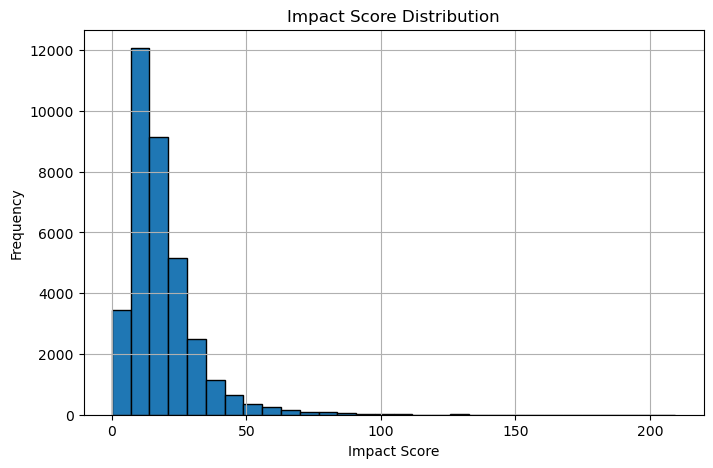

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(impact_df['impact_score'].dropna(), bins=30, edgecolor='black')
plt.title('Impact Score Distribution')
plt.xlabel('Impact Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 유사도 × 중요도

In [38]:
# 데이터 불러오기
impact_df = pd.read_csv('/Users/han-yeeun/final/db/news_2023_2025_with_stock_impact.csv')

In [39]:
# 기업명, 유사도 추출 개수 설정
target_company = '삼성전자'
top_n = 5

In [40]:
# 날짜 형식 변환
impact_df['wdate'] = pd.to_datetime(impact_df['wdate'])

In [41]:
# 기준 뉴스 선택 (해당 기업 포함 + 가장 최신 기사 1건, 중요도 포함)
filtered_df = impact_df[
    (impact_df['title'].str.contains(target_company, na=False)) &
    (impact_df['wdate'].dt.year == 2025)
][['wdate', 'title', 'article', 'url', 'impact_score']].sort_values('wdate', ascending=False)

if not filtered_df.empty:
    target_news = filtered_df.iloc[0]
    target_content = target_news['article']
    target_date = target_news['wdate']
else:
    print(f"[주의] '{target_company}' 관련 2025년 뉴스가 없습니다.")
    target_news = None
    target_content = ""
    target_date = pd.NaT

In [ ]:
# 비교군 설정
# - 2022~2024년
# - 최소 6개월 전
# - 기업명 포함

min_gap_days = 180  # 6개월 기준

compare_df = impact_df[
    (impact_df['wdate'].dt.year >= 2022) &
    (impact_df['wdate'].dt.year <= 2024) &
    ((impact_df['title'].str.contains(target_company, na=False)) |
     (impact_df['article'].str.contains(target_company, na=False))) &
    (impact_df['wdate'] <= target_date - timedelta(days=min_gap_days))
][['wdate', 'title', 'article', 'url', 'impact_score']].reset_index(drop=True)

In [46]:
def find_similar_news(model_name):
    print(f'\n모델: {model_name}')
    model = SentenceTransformer(model_name)

    # 기준 뉴스 임베딩
    start = time()
    target_embedding = model.encode([target_content])

    # 비교 뉴스 임베딩
    compare_embeddings = model.encode(compare_df['article'].tolist(), show_progress_bar=True)
    print(f'임베딩 완료: {time() - start:.2f}초')

    # 유사도 계산
    similarities = cosine_similarity(target_embedding, compare_embeddings)[0]
    compare_df['similarity'] = similarities
    compare_df['wdate'] = pd.to_datetime(compare_df['wdate'], errors='coerce')

    # 중요도 정규화 (impact_score → impact_score_norm)
    if compare_df['impact_score'].max() > 1:
        scaler = MinMaxScaler()
        compare_df['impact_score_norm'] = scaler.fit_transform(compare_df[['impact_score']])
    else:
        compare_df['impact_score_norm'] = compare_df['impact_score']  # 이미 정규화된 경우

    # 곱 연산 기반 유사도 × 중요도 점수
    compare_df['adjusted_score'] = compare_df['similarity'] * compare_df['impact_score_norm']

    # 점수 높은 순 정렬
    compare_df_sorted = compare_df.sort_values(by='adjusted_score', ascending=False).dropna(subset=['wdate'])

    # 기준 뉴스 날짜
    target_date = target_news['wdate']
    selected = []

    for _, row in compare_df_sorted.iterrows():
        candidate_date = row['wdate']

        # 조건 1: 기준 뉴스와 시차 ≥ 6개월
        if abs((target_date - candidate_date).days) < 180:
            continue

        # 조건 2: 기존 선택 뉴스들과 시차 ≥ 3개월
        if any(abs((candidate_date - sel['wdate']).days) < 90 for sel in selected):
            continue

        selected.append(row)
        if len(selected) == top_n:
            break

    result = pd.DataFrame(selected)
    return result

In [47]:
# 실행 1
result1 = find_similar_news('jhgan/ko-sbert-sts')

# 실행 2
result2 = find_similar_news('snunlp/KR-SBERT-V40K-klueNLI-augSTS')


모델: jhgan/ko-sbert-sts


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.59초

모델: snunlp/KR-SBERT-V40K-klueNLI-augSTS


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.04초


In [48]:
# 결과 확인 (곱연산 점수 기반)
print('\nTop-5 유사 뉴스 (jhgan 모델)')
for i, row in result1.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']}")
    print(f"   유사도: {row['similarity']:.4f}, 중요도: {row['impact_score']:.2f}, 유사도×중요도: {row['adjusted_score']:.4f}")
    print(f"   url: {row.get('url', 'N/A')}")
    print()

print('\nTop-5 유사 뉴스 (snunlp 모델)')
for i, row in result2.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']}")
    print(f"   유사도: {row['similarity']:.4f}, 중요도: {row['impact_score']:.2f}, 유사도×중요도: {row['adjusted_score']:.4f}")
    print(f"   url: {row.get('url', 'N/A')}")
    print()


Top-5 유사 뉴스 (jhgan 모델)
2831. [2024-03-04] "HBM장비 관련주 추가 모멘텀 기대…한미반도체 등 수혜"
   유사도: 0.6685, 중요도: 89.63, 유사도×중요도: 0.5919
   url: https://n.news.naver.com/mnews/article/015/0004955092

697. [2024-09-24] 배당·자사주 소각·흑자기업만 포함… "추가상승 여력 충분"[베일 벗은 '밸류업 지수']
   유사도: 0.5492, 중요도: 100.99, 유사도×중요도: 0.5492
   url: https://n.news.naver.com/mnews/article/014/0005244808

1747. [2024-06-09] AI 수혜주로 돈몰렸다…삼성전자·LG전자 찜
   유사도: 0.4770, 중요도: 86.01, 유사도×중요도: 0.4048
   url: https://n.news.naver.com/mnews/article/015/0004994612


Top-5 유사 뉴스 (snunlp 모델)
2831. [2024-03-04] "HBM장비 관련주 추가 모멘텀 기대…한미반도체 등 수혜"
   유사도: 0.7017, 중요도: 89.63, 유사도×중요도: 0.6212
   url: https://n.news.naver.com/mnews/article/015/0004955092

697. [2024-09-24] 배당·자사주 소각·흑자기업만 포함… "추가상승 여력 충분"[베일 벗은 '밸류업 지수']
   유사도: 0.5434, 중요도: 100.99, 유사도×중요도: 0.5434
   url: https://n.news.naver.com/mnews/article/014/0005244808

1747. [2024-06-09] AI 수혜주로 돈몰렸다…삼성전자·LG전자 찜
   유사도: 0.6198, 중요도: 86.01, 유사도×중요도: 0.5260
   url: https://n.news.naver.com/mnews/artic

## 유사도 × 중요도로 가중합 점수 계산

점수=α⋅유사도+(1−α)⋅중요도
- 한쪽이 낮아도 다른 쪽이 보완해줄 수 있음
    - e.g. α=0.7이라면, 유사도가 70%, 중요도가 30%의 비중을 차지함
    - 유사도는 0.75인데 중요도는 0.2 → 점수는 약 0.585가 되는 것

In [77]:
# 데이터 불러오기
impact_df = pd.read_csv('/Users/han-yeeun/final/db/news_2023_2025_with_stock_impact.csv')

In [78]:
# 기업명, 유사도 추출 개수 설정
target_company = '삼성전자'
top_n = 5

In [79]:
# 날짜 형식 변환
impact_df['wdate'] = pd.to_datetime(impact_df['wdate'])

In [80]:
# 기준 뉴스 선택 (해당 기업 포함 + 가장 최신 기사 1건, 중요도 포함)
filtered_df = impact_df[
    (impact_df['title'].str.contains(target_company, na=False)) &
    (impact_df['wdate'].dt.year == 2025)
][['wdate', 'title', 'article', 'url', 'impact_score']].sort_values('wdate', ascending=False)

if not filtered_df.empty:
    target_news = filtered_df.iloc[0]
    target_content = target_news['article']
    target_date = target_news['wdate']
else:
    print(f"[주의] '{target_company}' 관련 2025년 뉴스가 없습니다.")
    target_news = None
    target_content = ""
    target_date = pd.NaT

In [81]:
# 비교군 설정
# - 2022~2024년
# - 최소 6개월 전
# - 기업명 포함

min_gap_days = 180  # 6개월 기준

compare_df = impact_df[
    (impact_df['wdate'].dt.year >= 2022) &
    (impact_df['wdate'].dt.year <= 2024) &
    ((impact_df['title'].str.contains(target_company, na=False)) |
     (impact_df['article'].str.contains(target_company, na=False))) &
    (impact_df['wdate'] <= target_date - timedelta(days=min_gap_days))
][['wdate', 'title', 'article', 'url', 'impact_score']].reset_index(drop=True)

In [74]:
# 유사도 + 중요도 가중합 기반 유사 뉴스 찾기
def find_similar_news(model_name):
    print(f'\n모델: {model_name}')
    model = SentenceTransformer(model_name)

    # 기준 뉴스 임베딩
    start = time()
    target_embedding = model.encode([target_content])
    
    # 비교 뉴스 임베딩
    compare_embeddings = model.encode(compare_df['article'].tolist(), show_progress_bar=True)
    print(f'임베딩 완료: {time() - start:.2f}초')

    # 유사도 계산
    similarities = cosine_similarity(target_embedding, compare_embeddings)[0]
    compare_df['similarity'] = similarities
    compare_df['wdate'] = pd.to_datetime(compare_df['wdate'], errors='coerce')

    # 중요도 로그 변환 + 정규화 (impact_score → impact_score_log → impact_score_norm)
    compare_df['impact_score_log'] = np.log1p(compare_df['impact_score'])  # log(1 + x)
    scaler = MinMaxScaler()
    compare_df['impact_score_norm'] = scaler.fit_transform(compare_df[['impact_score_log']])

    # 가중합 점수 계산 (alpha = 0.75: 유사도 75%, 중요도 25%)
    alpha = 0.75
    compare_df['adjusted_score'] = (
        alpha * compare_df['similarity'] +
        (1 - alpha) * compare_df['impact_score_norm']
    )

    # 점수 높은 순 정렬
    compare_df_sorted = compare_df.sort_values(by='adjusted_score', ascending=False).dropna(subset=['wdate'])

    # 기준 뉴스 날짜
    target_date = target_news['wdate']
    selected = []

    for _, row in compare_df_sorted.iterrows():
        candidate_date = row['wdate']

        # 조건 1: 기준 뉴스와 시차 ≥ 6개월
        if abs((target_date - candidate_date).days) < 180:
            continue

        # 조건 2: 기존 선택 뉴스들과 시차 ≥ 3개월
        if any(abs((candidate_date - sel['wdate']).days) < 90 for sel in selected):
            continue

        selected.append(row)
        if len(selected) == top_n:
            break

    result = pd.DataFrame(selected)
    return result


In [75]:
# 실행 1
result1 = find_similar_news('jhgan/ko-sbert-sts')

# 실행 2
result2 = find_similar_news('snunlp/KR-SBERT-V40K-klueNLI-augSTS')


모델: jhgan/ko-sbert-sts


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.78초

모델: snunlp/KR-SBERT-V40K-klueNLI-augSTS


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 48.22초


In [76]:
# 결과 확인 (가중합 점수 기반)
print('\nTop-5 유사 뉴스 (jhgan 모델)')
for i, row in result1.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']}")
    print(f"   유사도: {row['similarity']:.4f}, 중요도: {row['impact_score']:.2f}, 유사도×중요도: {row['adjusted_score']:.4f}")
    print(f"   url: {row.get('url', 'N/A')}")
    print()

print('\nTop-5 유사 뉴스 (snunlp 모델)')
for i, row in result2.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']}")
    print(f"   유사도: {row['similarity']:.4f}, 중요도: {row['impact_score']:.2f}, 유사도×중요도: {row['adjusted_score']:.4f}")
    print(f"   url: {row.get('url', 'N/A')}")
    print()


Top-5 유사 뉴스 (jhgan 모델)
2831. [2024-03-04] "HBM장비 관련주 추가 모멘텀 기대…한미반도체 등 수혜"
   유사도: 0.6685, 중요도: 89.63, 유사도×중요도: 0.7431
   url: https://n.news.naver.com/mnews/article/015/0004955092

1679. [2024-06-16] 2분기 실적 기대주 주목... 삼성전자·LIG넥스원 ‘픽’[株슐랭가이드]
   유사도: 0.7350, 중요도: 25.55, 유사도×중요도: 0.7062
   url: https://n.news.naver.com/mnews/article/014/0005199753

697. [2024-09-24] 배당·자사주 소각·흑자기업만 포함… "추가상승 여력 충분"[베일 벗은 '밸류업 지수']
   유사도: 0.5492, 중요도: 100.99, 유사도×중요도: 0.6619
   url: https://n.news.naver.com/mnews/article/014/0005244808


Top-5 유사 뉴스 (snunlp 모델)
2831. [2024-03-04] "HBM장비 관련주 추가 모멘텀 기대…한미반도체 등 수혜"
   유사도: 0.7017, 중요도: 89.63, 유사도×중요도: 0.7679
   url: https://n.news.naver.com/mnews/article/015/0004955092

728. [2024-09-23] '안된다는 생각을 버려라' 대체할 삼성의 새 '반도체인 신조'는
   유사도: 0.7423, 중요도: 29.71, 유사도×중요도: 0.7219
   url: https://n.news.naver.com/mnews/article/001/0014941048

1703. [2024-06-13] "엔비디아 인증 가능성 높다"…삼성전자의 시간 온다-삼성증권
   유사도: 0.7597, 중요도: 22.96, 유사도×중요도: 0.7175
   url: https://n.news.naver.com/

In [82]:
# 최적 alpha 찾기
def find_best_alpha_news(model_name, top_n=5, alphas=np.arange(0.5, 1.0, 0.05)):
    print(f'\n모델: {model_name}')
    model = SentenceTransformer(model_name)

    # 기준 뉴스 임베딩
    start = time()
    target_embedding = model.encode([target_content])
    
    # 비교 뉴스 임베딩
    compare_embeddings = model.encode(compare_df['article'].tolist(), show_progress_bar=True)
    print(f'임베딩 완료: {time() - start:.2f}초')

    # 유사도 계산
    similarities = cosine_similarity(target_embedding, compare_embeddings)[0]
    compare_df['similarity'] = similarities
    compare_df['wdate'] = pd.to_datetime(compare_df['wdate'], errors='coerce')

    # 중요도 로그 변환 + 정규화
    compare_df['impact_score_log'] = np.log1p(compare_df['impact_score'])
    scaler = MinMaxScaler()
    compare_df['impact_score_norm'] = scaler.fit_transform(compare_df[['impact_score_log']])

    target_date = target_news['wdate']
    best_alpha = 0
    best_impact = -1
    best_result = None

    for alpha in alphas:
        compare_df['adjusted_score'] = (
            alpha * compare_df['similarity'] +
            (1 - alpha) * compare_df['impact_score_norm']
        )
        compare_df_sorted = compare_df.sort_values(by='adjusted_score', ascending=False).dropna(subset=['wdate'])

        selected = []
        for _, row in compare_df_sorted.iterrows():
            candidate_date = row['wdate']
            if abs((target_date - candidate_date).days) < 180:
                continue
            if any(abs((candidate_date - sel['wdate']).days) < 90 for sel in selected):
                continue
            selected.append(row)
            if len(selected) == top_n:
                break

        result_df = pd.DataFrame(selected)
        avg_impact = result_df['impact_score'].mean()

        if avg_impact > best_impact:
            best_impact = avg_impact
            best_alpha = alpha
            best_result = result_df.copy()

    print(f'\n최적 alpha: {best_alpha:.2f} (Top-{top_n} 뉴스의 평균 중요도 = {best_impact:.2f})')
    return best_result

In [83]:
# 실행 1 
result1 = find_best_alpha_news('jhgan/ko-sbert-sts', top_n=5)

# 실행 2
result2 = find_best_alpha_news('snunlp/KR-SBERT-V40K-klueNLI-augSTS', top_n=5)


모델: jhgan/ko-sbert-sts


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 49.21초

최적 alpha: 0.50 (Top-5 뉴스의 평균 중요도 = 92.21)

모델: snunlp/KR-SBERT-V40K-klueNLI-augSTS


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

임베딩 완료: 49.05초

최적 alpha: 0.50 (Top-5 뉴스의 평균 중요도 = 92.21)


In [84]:
# 결과 확인 (가중합 점수 기반)
print('\nTop-5 유사 뉴스 (jhgan 모델)')
for i, row in result1.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']}")
    print(f"   유사도: {row['similarity']:.4f}, 중요도: {row['impact_score']:.2f}, 유사도×중요도: {row['adjusted_score']:.4f}")
    print(f"   url: {row.get('url', 'N/A')}")
    print()

print('\nTop-5 유사 뉴스 (snunlp 모델)')
for i, row in result2.head(5).iterrows():
    print(f"{i+1}. [{row['wdate'].date()}] {row['title']}")
    print(f"   유사도: {row['similarity']:.4f}, 중요도: {row['impact_score']:.2f}, 유사도×중요도: {row['adjusted_score']:.4f}")
    print(f"   url: {row.get('url', 'N/A')}")
    print()


Top-5 유사 뉴스 (jhgan 모델)
2831. [2024-03-04] "HBM장비 관련주 추가 모멘텀 기대…한미반도체 등 수혜"
   유사도: 0.6685, 중요도: 89.63, 유사도×중요도: 0.8176
   url: https://n.news.naver.com/mnews/article/015/0004955092

697. [2024-09-24] 배당·자사주 소각·흑자기업만 포함… "추가상승 여력 충분"[베일 벗은 '밸류업 지수']
   유사도: 0.5492, 중요도: 100.99, 유사도×중요도: 0.7746
   url: https://n.news.naver.com/mnews/article/014/0005244808

1747. [2024-06-09] AI 수혜주로 돈몰렸다…삼성전자·LG전자 찜
   유사도: 0.4770, 중요도: 86.01, 유사도×중요도: 0.7160
   url: https://n.news.naver.com/mnews/article/015/0004994612


Top-5 유사 뉴스 (snunlp 모델)
2831. [2024-03-04] "HBM장비 관련주 추가 모멘텀 기대…한미반도체 등 수혜"
   유사도: 0.7017, 중요도: 89.63, 유사도×중요도: 0.8342
   url: https://n.news.naver.com/mnews/article/015/0004955092

1747. [2024-06-09] AI 수혜주로 돈몰렸다…삼성전자·LG전자 찜
   유사도: 0.6198, 중요도: 86.01, 유사도×중요도: 0.7874
   url: https://n.news.naver.com/mnews/article/015/0004994612

697. [2024-09-24] 배당·자사주 소각·흑자기업만 포함… "추가상승 여력 충분"[베일 벗은 '밸류업 지수']
   유사도: 0.5434, 중요도: 100.99, 유사도×중요도: 0.7717
   url: https://n.news.naver.com/mnews/artic

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


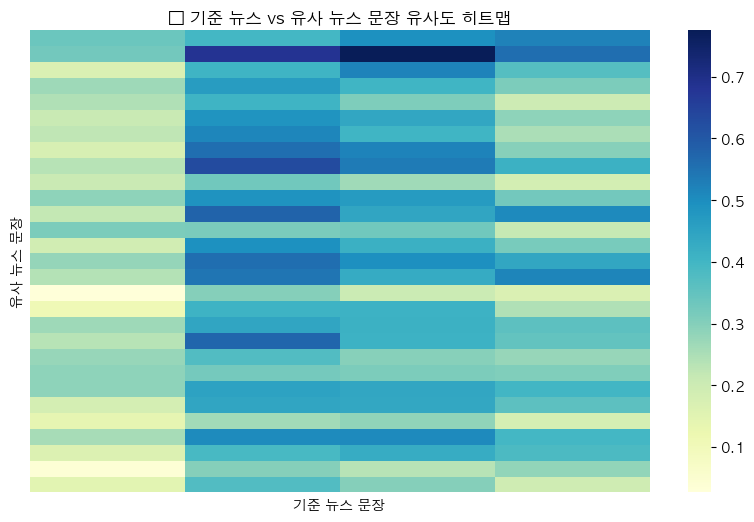

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

def plot_coverage_heatmap(base_text, compare_text, model_name='snunlp/KR-SBERT-V40K-klueNLI-augSTS'):
    model = SentenceTransformer(model_name)

    base_sents = [s.strip() for s in base_text.split('. ') if len(s.strip()) > 5]
    comp_sents = [s.strip() for s in compare_text.split('. ') if len(s.strip()) > 5]

    base_emb = model.encode(base_sents)
    comp_emb = model.encode(comp_sents)

    sim_matrix = cosine_similarity(comp_emb, base_emb)

    plt.figure(figsize=(10, 6))
    sns.heatmap(sim_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
    plt.title("기준 뉴스 vs 유사 뉴스 문장 유사도 히트맵")
    plt.xlabel("기준 뉴스 문장")
    plt.ylabel("유사 뉴스 문장")
    plt.show()

    return sim_matrix
# 기준 뉴스와 유사 뉴스 문장 유사도 히트맵 시각화
if target_news is not None:
    base_text = target_news['article']
    compare_text = result1['article'].str.cat(sep=' ')
    sim_matrix = plot_coverage_heatmap(base_text, compare_text, model_name='snunlp/KR-SBERT-V40K-klueNLI-augSTS')